In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RepeatVector

import matplotlib as mpl
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

# seeding for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

matplotlib.rcParams['figure.figsize'] = (24, 18)
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams.update({'font.size': 20})

TRAIN_SIZE = 9800
TRAIN_TIME = 6
BATCH_SIZE = 32
BUFFER_SIZE = 500

In [2]:
total_ped_matrix = np.load("../details/ego_ped_matrix.npy")

with open("../details/ped_dataset.pkl", 'rb') as f:
    ped_dataset = pickle.load(f)
    
with open("../details/scene_info.pkl", 'rb') as handle:
    scene_info = pickle.load(handle)

In [13]:
nusc = NuScenes(version='v1.0-trainval', 
                dataroot='../../../../../data/', 
                verbose=False)

so_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-onenorth')
bs_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='boston-seaport')
sh_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-hollandvillage')
sq_map = NuScenesMap(dataroot='../../../../../data/', 
                       map_name='singapore-queenstown')

# dict mapping map name to map file
map_files = {'singapore-onenorth': so_map,
             'boston-seaport': bs_map,
             'singapore-hollandvillage': sh_map,
             'singapore-queenstown': sq_map}

In [3]:
# # calculating the values for standardization for every feature
# mean_values = np.mean(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))
# std_values = np.std(total_ped_matrix[:TRAIN_SIZE, :TRAIN_TIME, :], axis=(0,1))

# # standardization
# total_ped_matrix = (total_ped_matrix - mean_values) / std_values

In [4]:
# train_test split
x_train = total_ped_matrix[:TRAIN_SIZE, :, :TRAIN_TIME, :]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[2],
                              x_train.shape[1]*x_train.shape[3])) # reshaping into 3D
xn_train = np.zeros((x_train.shape[0],x_train.shape[1],
                     x_train.shape[2]+1))
for xi in range(len(x_train)):
    layer_numbers = []
    for cur_layers in ped_dataset[xi]["ped_layers"][:TRAIN_TIME]:
        if "walkway" in cur_layers:
            layer_numbers.append(0.)
        else:
            layer_numbers.append(1.)
    xn_train[xi] = np.append(x_train[xi], 
                           np.array(layer_numbers)[:,np.newaxis],
                           axis=1)

y_train1 = total_ped_matrix[:TRAIN_SIZE, 0, TRAIN_TIME:, :2]
y_train = np.zeros((y_train1.shape[0], y_train1.shape[1], 4))
for xi in range(len(x_train)):
    layer_numbers = []
    for cur_layers in ped_dataset[xi]["ped_layers"][TRAIN_TIME:]:
        if "walkway" in cur_layers:
            layer_numbers.append(0.)
        else:
            layer_numbers.append(1.)
    y_train2 = np.append(y_train1[xi], 
                         np.array(layer_numbers)[:,np.newaxis],
                         axis=1)
    y_train3 = np.array([xi for _ in range(y_train1.shape[1])])
    y_train[xi] = np.append(y_train2,
                        y_train3[:,np.newaxis], axis=1)


x_test = total_ped_matrix[TRAIN_SIZE:, :, :TRAIN_TIME, :]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[2], 
                              x_test.shape[1]*x_test.shape[3])) # reshaping into 3D
xn_test = np.zeros((x_test.shape[0], x_test.shape[1],
                    x_test.shape[2]+1))
for xi in range(len(x_test)):
    layer_numbers = []
    for cur_layers in ped_dataset[xi+TRAIN_SIZE]["ped_layers"][:TRAIN_TIME]:
        if "walkway" in cur_layers:
            layer_numbers.append(0.)
        else:
            layer_numbers.append(1.)
    xn_test[xi] = np.append(x_test[xi], 
                           np.array(layer_numbers)[:,np.newaxis],
                           axis=1)

y_test1 = total_ped_matrix[TRAIN_SIZE:, 0, TRAIN_TIME:, :2]
y_test = np.zeros((y_test1.shape[0], y_test1.shape[1], 4))
for xi in range(len(x_test)):
    layer_numbers = []
    for cur_layers in ped_dataset[xi+TRAIN_SIZE]["ped_layers"][TRAIN_TIME:]:
        if "walkway" in cur_layers:
            layer_numbers.append(0.)
        else:
            layer_numbers.append(1.)
    y_test2 = np.append(y_test1[xi], 
                        np.array(layer_numbers)[:,np.newaxis],
                        axis=1)
    y_test3 = np.array([xi+TRAIN_SIZE for _ in range(y_test1.shape[1])])
    y_test[xi] = np.append(y_test2,
                           y_test3[:,np.newaxis], axis=1)

In [11]:
train_data = tf.data.Dataset.from_tensor_slices((xn_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((xn_test, y_test))
val_data = val_data.batch(BATCH_SIZE).repeat()

In [14]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

In [22]:
# defining the custom rmse loss function
def layer_loss(pred_path, gt_layer):
    tot_diff = 0.0
    gt_list = gt_layer[:,:,0]
    scene_idx = gt_layer[:,0,1]
    for i in range(pred_path.shape[0]): #batch
        cur_idx = scene_idx[i]
        gt_layers = gt_list[i]
        pred_layers = []
        for j in range(pred_path.shape[1]):
            n_scene = ped_dataset[cur_idx]["scene_no"]
            cur_pred_path = move_from_origin(rotate_from_y(pred_path[i], 
                             ped_dataset[cur_idx]["angle"]),
                             ped_dataset[cur_idx]["origin"])
            cur_layers = map_files[scene_info[str(n_scene)]["map_name"]].layers_on_point(
                cur_pred_path[j][0],
                cur_pred_path[j][1]
            )
            if cur_layers["walkway"]:
                pred_layers.append(0.)
            else:
                pred_layers.append(1.)
        pred_layers = np.array(pred_layers)
        tot_diff += np.sum(np.absolute(gt_layers-pred_layers))
    return np.float32(tot_diff/float(len(pred_path)))  

def model_loss(gt, pred_path):
    '''
    calculates custom rmse loss between every time point
    '''
    gt_path = gt[:,:,:2]
    rmse_error = K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))
    
    gt_layer = gt[:,:,2:]
    layer_error = tf.numpy_function(layer_loss, [pred_path, gt_layer], tf.float32)
    return rmse_error + (layer_error/2.0)

def euc_dist(gt_path, pred_path):
    # custom metric to monitor rmse
    gt_path = gt_path[:,:,:2]
    return K.mean(K.sqrt(K.sum(K.square(gt_path-pred_path), axis=1)))     

In [23]:
lstm_model = tf.keras.models.Sequential()
lstm_model.add(LSTM(32, input_shape=xn_train.shape[-2:]))
lstm_model.add(RepeatVector(10))
lstm_model.add(LSTM(16, return_sequences=True,activation='relu'))
lstm_model.add(LSTM(8, return_sequences=True,activation='relu'))
lstm_model.add(TimeDistributed(
                Dense(2, activation='linear')))

lstm_model.compile(optimizer='adam', 
                       loss=model_loss, metrics=[euc_dist])

In [24]:
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 32)                6144      
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 10, 16)            3136      
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 8)             800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 2)             18        
Total params: 10,098
Trainable params: 10,098
Non-trainable params: 0
_________________________________________________________________


In [25]:
# checkpoint for saving the best model
filepath="../checkpoints/lstm_map.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_euc_dist', 
                                                verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

train_history = lstm_model.fit(train_data, epochs=40,
                         verbose=0, callbacks=callbacks_list,
                         validation_data=val_data,
                         steps_per_epoch=300,
                         validation_steps=70
                         )

KeyboardInterrupt: 

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

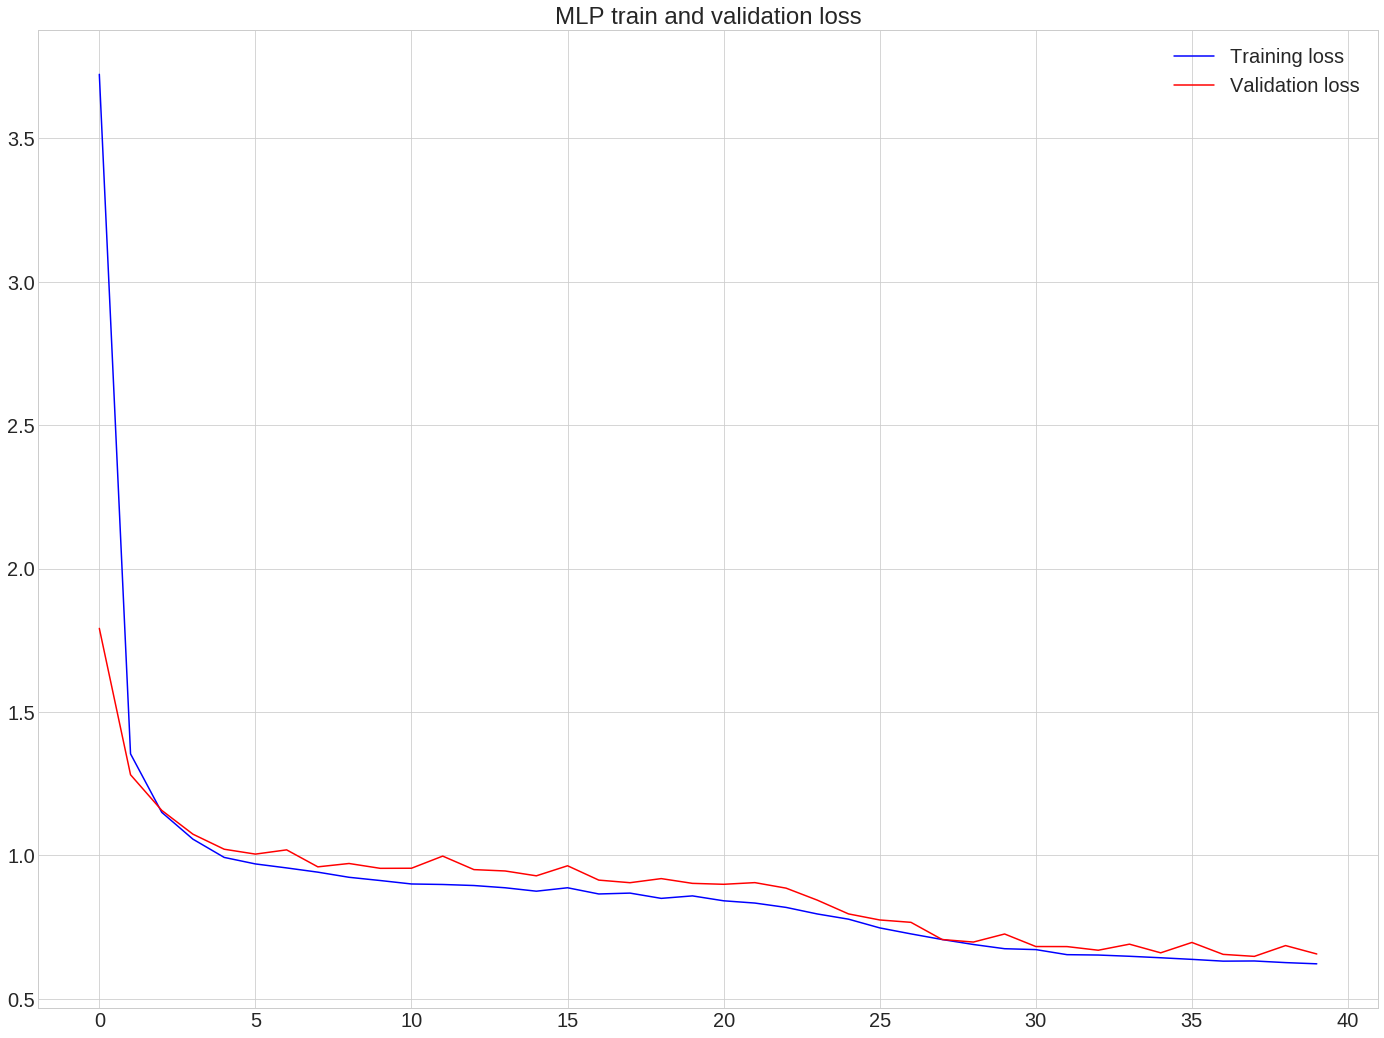

In [11]:
plot_train_history(train_history, "MLP train and validation loss")

In [12]:
# undo normalization for plotting
def move_from_origin(l, origin):
    x0, y0 = origin
    return [[x + x0, y + y0] for x, y in l]

def rotate_from_y(l, angle):
    theta = -angle
    return [(x*np.cos(theta) - y*np.sin(theta), 
                    x*np.sin(theta) + y*np.cos(theta)) for x, y in l]

# loss calculation for test prediction
def rmse_error(l1, l2):
    loss = 0.0
    
    if len(np.array(l1).shape) < 2:
        return ((l1[0] - l2[0])**2 + (l1[1] - l2[1])**2)**0.5
    for p1, p2 in zip(l1, l2):
        loss += ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5
    return (loss / float(len(l1)))

In [13]:
ade_values = []
fde_values = []

for test_idx in range(TRAIN_SIZE, len(ped_dataset)):
    test_data = total_ped_matrix[test_idx:test_idx+1,:,:6,:]
    test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[2],
                                       test_data.shape[1]*test_data.shape[3]))
    predictions = lstm_model.predict(test_data).reshape(-1, 2)
    predictions = move_from_origin(rotate_from_y(predictions, ped_dataset[test_idx]["angle"]),
                                   ped_dataset[test_idx]["origin"])

#     n_scene = ped_dataset[test_idx]["scene_no"]
#     ego_poses = map_files[scene_info[str(n_scene)]["map_name"]].render_egoposes_on_fancy_map(
#                     nusc, scene_tokens=[nusc.scene[n_scene]['token']], verbose=False,
#                     render_egoposes=True, render_egoposes_range=False, 
#                     render_legend=False)

#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[:6,:2]), c='k', s=5, zorder=2)
#     plt.scatter(*zip(*np.array(ped_dataset[test_idx]["translation"])[6:,:2]), c='b', s=5, zorder=3)
#     plt.scatter(*zip(*predictions), c='r', s=5, zorder=4)
#     plt.show()
    
    loss = rmse_error(predictions, 
                      np.array(ped_dataset[test_idx]["translation"])[6:,:2])
    final_loss = rmse_error(predictions[-1], 
                            np.array(ped_dataset[test_idx]["translation"])[-1,:2])

    
#     print(f"Loss in m is {loss}")
#     print(f"Loss of final position in m is {final_loss}")
    
    ade_values.append(loss)
    fde_values.append(final_loss)
    
print(np.mean(np.array(ade_values)))
print(np.mean(np.array(fde_values)))

0.2986622909962153
0.5110788555060514


In [26]:
!jupyter nbconvert --to script LSTM_map.ipynb

[NbConvertApp] Converting notebook LSTM_map.ipynb to script
[NbConvertApp] Writing 11118 bytes to LSTM_map.py
